In [5]:
import os
import math
import numpy as np
import pandas as pd
import scipy.io as scio
import scipy.stats as stat
import matplotlib.pyplot as plt
%matplotlib inline
from behaviorIO import *

In [22]:
# Basic info directory containing the mouse data
basedir = 'D:/User Folders/Trent/MixedValenceBehavior'
rig = 'ephys'

# Mouse, date, run info
mouse='LR9'
date = '180622'
runs = [1,2,3]

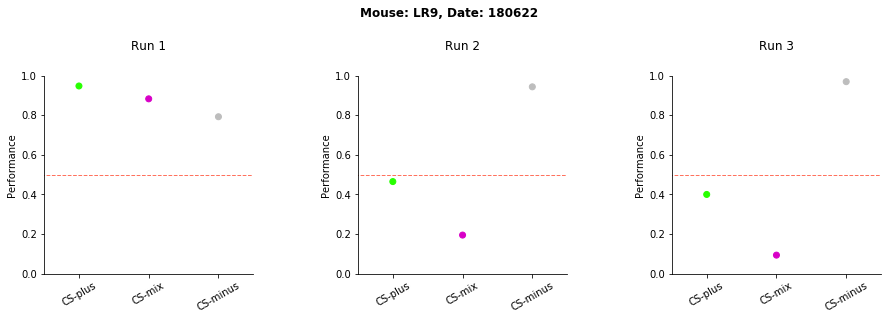

In [23]:
# Plots performance summary for individual mice

fig, ax = plt.subplots(1, len(runs), figsize=(5*len(runs), 4))
for i, run in enumerate(runs):
    bhv, trialerror = loadBhv(mouse, date, run, basedir)
    
    Hit = len(trialerror[trialerror['TrialError'] == 2])
    Miss = len(trialerror[trialerror['TrialError'] == 3])
    plus = Hit / (Hit + Miss)

    CR = len(trialerror[trialerror['TrialError'] == 4])
    FA = len(trialerror[trialerror['TrialError'] == 5])
    minus = CR / (CR + FA)

    Accept = len(trialerror[trialerror['TrialError'] == 0])
    Reject = len(trialerror[trialerror['TrialError'] == 1])
    mix = Accept / (Accept + Reject)

    ax[i].scatter(['CSplus', 'CSmix', 'CSminus'], [plus, mix, minus], c=['#27FF00', '#D800C7', '#BDBDBD'])
    # Draw the chance line
    ax[i].hlines(0.5,-1,3, color='#FF4F36', linestyle='--', linewidth=1, alpha=.8)
    
    ax[i].set_ylim([0., 1.1])
    ax[i].set_xlim([-0.5, 2.5])

    ax[i].set_ylabel('Performance')
    ax[i].set_title('Run '+str(run))

    # Only draw spine between the y-ticks
    ax[i].xaxis.set_ticks_position('bottom')
    ax[i].set_xticklabels(labels=['CS-plus', 'CS-mix', 'CS-minus'], rotation=30, ha='center')
    # Hide the right and top spines
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['left'].set_bounds(0, 1)
    ax[i].yaxis.set_ticks_position('left')

plt.suptitle('Mouse: '+mouse+', Date: '+date, y=1.05, weight='bold')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)

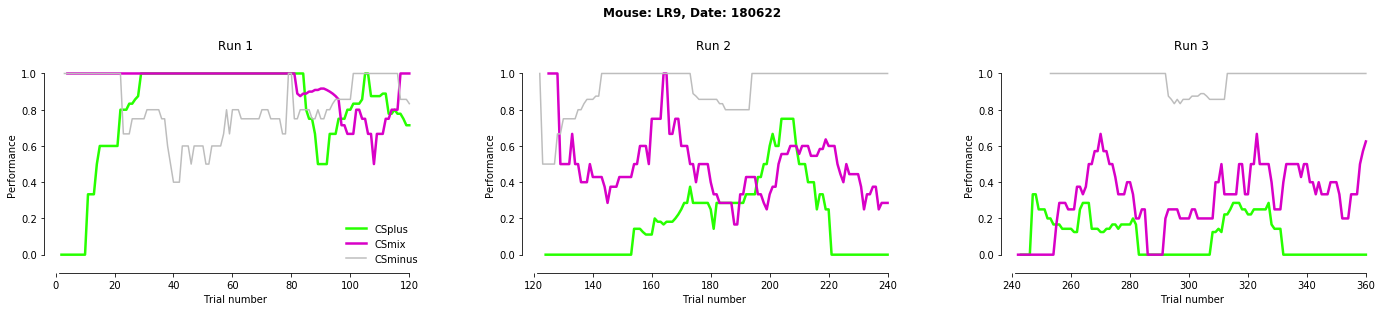

In [24]:
# Momentary performance
# Plots performance over a sliding window
window = 20

runLen = {}
length = 0
fig, ax = plt.subplots(1, len(runs), figsize=(len(runs)*8, 4))
for i, run in enumerate(runs):
    bhv, trialerror = loadBhv(mouse, date, run, basedir)
    runLen[run] = len(trialerror)
    length = length + len(trialerror)

    rolling = pd.DataFrame([])
    for err in np.arange(0,10):
        temp = []
        for ind, row in trialerror.iterrows():
            if ind < window:
                temp.append(np.sum(trialerror['TrialError'][0:ind] == err))
            else:
                temp.append(np.sum(trialerror['TrialError'][ind-window:ind] == err))
        rolling[err] = temp
    
    trials = np.arange(length-runLen[run], length) + 1
    csmix, = ax[i].plot(trials, rolling[0] / (rolling[0] + rolling[1]), '#27FF00', label='CSplus', linewidth=2.5)
    csp, = ax[i].plot(trials, rolling[2] / (rolling[2] + rolling[3]), '#D800C7', label='CSmix', linewidth=2.5)
    csm, = ax[i].plot(trials, rolling[4] / (rolling[4] + rolling[5]), '#BDBDBD', label='CSminus', linewidth=1.5)

    ax[i].set_ylim([-.1, 1.1])
    ax[i].set_ylabel('Performance')
    ax[i].set_title('Run '+str(run))
    ax[i].set_xlabel('Trial number')

    # Only draw spine between the y-ticks
    ax[i].spines['bottom'].set_bounds(trials[0], np.ceil(trials[-1]/10)*10)
    ax[i].xaxis.set_ticks_position('bottom')
    # Hide the right and top spines
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['left'].set_bounds(0, 1)
    ax[i].yaxis.set_ticks_position('left')

plt.suptitle('Mouse: '+mouse+', Date: '+date, y=1.05, weight='bold')

ax[0].legend(frameon=False)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=None)

In [ ]:
## Plots mean performance for runs over multiple mice
# Needs mathcing runs

# Basic info
basedir = 'D:/User Folders/Trent/MixedValenceBehavior'

mice= ['HK02','HK03', 'HK08', 'HK09']
dates = ['181123', '181122', '181122', '181123']
runs = [1,2]
avorunav = 'avoidable'

performance = pd.DataFrame([])
for i, run in enumerate(runs):
    for k in np.arange(0, len(mice)):
        mouse = mice[k]
        date = dates[k]
        path = callpath(basedir, mouse, date, run, 'bhv')
        bhv = scio.loadmat(path, squeeze_me=0)
        trialerror = pd.DataFrame(bhv['BHV']['TrialError'][0][0].reshape(len(bhv['BHV']['TrialError'][0][0])), columns=['TrialError'])

        Hit = len(trialerror[trialerror['TrialError'] == 2])
        Miss = len(trialerror[trialerror['TrialError'] == 3])
        plus = Hit / (Hit + Miss)

        CR = len(trialerror[trialerror['TrialError'] == 4])
        FA = len(trialerror[trialerror['TrialError'] == 5])
        minus = CR / (CR + FA)

        Accept = len(trialerror[trialerror['TrialError'] == 0])
        Reject = len(trialerror[trialerror['TrialError'] == 1])
        mix = Accept / (Accept + Reject)
        
        temp = pd.DataFrame({'mouse':[mouse], 'date':[date], 'run':[run], 'CSplus':[plus], 'CSmix':[mix], 'CSminus':[minus]})
        performance = pd.concat([performance, temp], ignore_index=True)

fig, ax = plt.subplots(1, len(runs), figsize=(len(runs)*4, 4))
for i, run in enumerate(runs):
    perf = performance.pivot_table(index=['run'], aggfunc=np.mean)
    perf_sem = performance.pivot_table(index=['run'], aggfunc=stat.sem)
    perf.loc[run].reindex(['CSplus', 'CSmix', 'CSminus']).plot(ax=ax[i], x=['CSplus', 'CSmix', 'CSminus'], y='run', kind='bar', colors=['#27FF00', '#D800C7', '#BDBDBD'], yerr=perf_sem.loc[run], width=.7)

    ax[i].set_ylim([0, 1.1])
    ax[i].set_ylabel('Performance')
    ax[i].set_title('Run '+str(run))

    # Only draw spine between the y-ticks
    ax[i].xaxis.set_ticks_position('bottom')
    ax[i].set_xticklabels(labels=['CS-plus', 'CS-mix', 'CS-minus'], rotation=30, ha='center')
    # Hide the right and top spines
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['left'].set_bounds(0, 1)
    ax[i].yaxis.set_ticks_position('left')

plt.suptitle('Mean performances: '+avorunav+' (n= '+str(len(mice))+')', y=1.05,  weight='bold')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)